# Standard imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from scipy.integrate import odeint, solve_ivp

# Custom imports that are either local or pulled from github

In [ ]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

# Imports related to model predictive control and pybounds

In [ ]:
try:
    import math
except:
    !pip install math
    import math
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

# Battery-Drill dynamics.

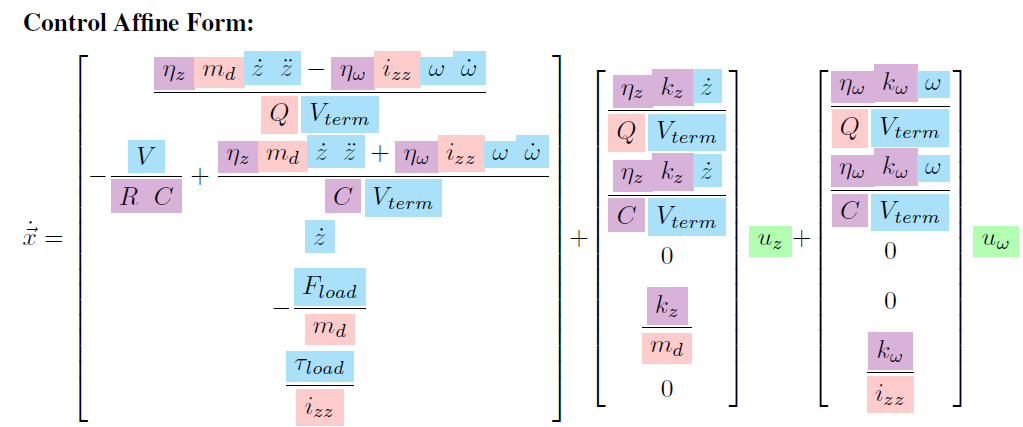

# Set some constant parameters (the pink symbols above)

In [ ]:
params = {
  'Q': 50000, # Battery Capacity (mAh)
  'R0': 0.05, # Ohmic resistance (ohms)
  'R_rc': 0.5, # RC branch resistance (ohms)
  'C_rc': 50.0, # RC branch capacitance (Farads)
  'm_d': 5.0, # mass (kg)
  'r_d': 0.1, # drill base radius (m)
  'k_F': 1.0, # Force constant for linear actuator
  'k_tau': 1.0, # Torque constant for rotary drill
  'eta_F': 0.6, # Linear actuator battery efficiency
  'eta_tau': 0.5, # Rotary drill battery efficiency
  'V_min': 3.0, # Minimum voltage of battery
  'V_max': 12.0, # Maximum voltage of battery
  'k_z': 1.0, # Soil Stiffness parameter
  'c_z': 1.0, # Soil damping parameter
  'k_omega': 2.0, # Soil friction parameter
  'c_omega': 0.1, # Viscous rotational resistance
}

params['Q_sec'] = (params["Q"] * 60.0 * 60.0) / 1000.0 # Battery Capacity (A sec)
params['i_zz'] = round(0.3 * params["m_d"] * (params["r_d"]**2.0), 3) # moment of inertia (Small rotating drill head)

print(params)

I_list = []
I_list.append(0.0)
u_list = []

# Set some helper functions

In [ ]:
# Simple soil force model
def soil_force(z, z_dot, k_z=5.0, c_z=1.0):
    # return 1.0
    """
    Resistive soil penetration force.

    Parameters
    ----------
    z : float
        Penetration depth [m]
    z_dot : float
        Penetration velocity [m/s]
    k_z : float
        Depth-dependent resistance [N/m]
    c_z : float
        Velocity-dependent damping [N·s/m]
    """
    return k_z * z + c_z * z_dot


# Simple soil torque model
def soil_torque(z, omega, k_tau=5.0, c_tau=0.1):
    # return 1.0
    """
    Resistive drilling torque from soil.

    Parameters
    ----------
    z : float
        Penetration depth [m]
    omega : float
        Rotational speed [rad/s]
    k_tau : float
        Depth-dependent torque constant [N·m/m]
    c_tau : float
        Rotational damping [N·m·s]
    """
    return k_tau * z + c_tau * omega

# Return mechanical power and total efficiency (eta)
def get_mechanical_power(k_F, u_F, z_dot, k_tau, u_tau, omega, eta_F, eta_tau):

    # Mechanical powers
    P_F = k_F * u_F * z_dot
    P_tau = k_tau * u_tau * omega
    P_mech = P_F + P_tau

    # Effective total efficiency
    if (P_F == 0 and P_tau == 0):
        eta_tot = 1.0  # no load case
    else:
        eta_tot = (P_mech) / ((P_F / eta_F) + (P_tau / eta_tau))

    eta_tot = np.clip(eta_tot, 1e-3, 1.0)

    return P_mech, eta_tot

# Nonlinear VOC function for battery
def voc_func(s, V_min, V_max):
    """
    Simple nonlinear Open Circuit Voltage (VOC) as a function of SOC.

    Parameters
    ----------
    s : float or ndarray
        State of charge in [0, 1]

    Returns
    -------
    V_oc : float or ndarray
        Open circuit voltage [V]
    """
    # Ensure SOC is in [0,1]
    s = np.clip(s, 1e-3, 1.0)

    # Nonlinear curve: a sigmoid-like shape common in Li-ion cells
    V_oc = V_min + (V_max - V_min) * (1 / (1 + np.exp(-10 * (s - 0.5))))

    V_oc = np.clip(V_oc, V_min, V_max)

    return V_oc

In [ ]:
def terminal_voltage_quadratic(s, v_rc, P_mech, eta_tot, params):
    """
    Solve the quadratic for terminal voltage V_term.

    Inputs
    ------
    s : float
        Battery state of charge (SOC)
    v_rc : float
        RC branch voltage
    P_mech : float
        Mechanical power load (F_load * z_dot + tau_load * omega)
    eta_tot : float
        Total electromechanical efficiency
    params : dict
        Parameter dictionary with at least:
        - "V_min", "V_max", "R0"
    voc_func : callable
        Function returning open-circuit voltage: V_oc = voc_func(s, V_min, V_max)

    Returns
    -------
    V_term : float
        Terminal voltage (positive root of quadratic, with guards)
    """

    # Open-circuit voltage
    V_min = params["V_min"]
    V_max = params["V_max"]
    R0    = params["R0"]
    V_oc  = voc_func(s, V_min, V_max)

    # Quadratic coefficients
    a = 1.0
    b = V_oc - v_rc
    c = (R0 / max(eta_tot, 1e-12)) * P_mech

    # Discriminant
    disc = b**2 - 4*a*c

    if disc < 0:
        if disc > -1e-12:
            # Clamp very small negative due to floating-point
            disc = 0.0
        else:
            # Fallback if no real solution: use safe approx
            V_term = max(V_oc - v_rc, V_min)
            return V_term

    # Positive root
    V_term = (b + np.sqrt(disc)) / (2*a)

    # Ensure physically valid voltage
    if V_term < V_min:
        V_term = V_min
    elif V_term > V_max:
        V_term = V_max

    return V_term

# Define your dynamics function

We will use this same format many times, for evaluating observability and Kalman filters.

<span style="color:blue;">AI tip: try an LLM to convert a picture of the dynamics, or the latex code, to a python function. You may have to correct it!

In [ ]:
def drilling_dynamics(x, u, params=params):
    """
    Continuous-time dynamics for the drilling system.

    Inputs
    ------
    x : array_like, shape (7,)
        State vector [s, v_rc, z, z_dot, omega, k_F, k_tau]
        s      : battery SOC
        v_rc   : RC branch voltage
        z      : drill penetration depth
        z_dot  : drill penetration speed
        omega  : drill rotational speed
        k_F    : control force constant
        k_tau  : control torque constant

    u : array_like, shape (2,)
        Control vector [u_F, u_tau]
        u_F     : linear actuator force input
        u_tau : drill motor torque input

    params : dict
        Dictionary of system parameters:
        Q      : battery capacity (mAh)
        Q_sec  : battery capacity (As)
        R0     : ohmic resistance
        R_rc   : RC resistance
        C_rc   : RC capacitance
        m_d    : drill mass
        r_d    : drill radius
        i_zz   : drill inertia
        eta_F  : actuator efficiency
        eta_tau : motor efficiency
        V_min : minimum voltage
        V_max : maximum voltage


    Output
    ------
    x_dot : ndarray, shape (7,)
        Time derivative of state vector
    """

    # Unpack state variables
    # s, v_rc, z, z_dot, omega = x
    s = x[0]
    v_rc = x[1]
    z = x[2]
    z_dot = x[3]
    omega = x[4]
    k_F = x[5]
    k_tau = x[6]

    # Unpack controls
    u_F = u[0]
    u_tau = u[1]

    # Unpack parameters
    Q = params["Q"]
    Q_sec = params["Q_sec"]
    R0 = params["R0"]
    R = params["R_rc"]
    C = params["C_rc"]
    m_d = params["m_d"]
    i_zz = params["i_zz"]
    eta_F = params["eta_F"]
    eta_tau = params["eta_tau"]
    V_min = params["V_min"]
    V_max = params["V_max"]

    k_z = params["k_z"]
    c_z = params["c_z"]
    k_omega = params["k_omega"]
    c_omega = params["c_omega"]

    # Safety term
    s = np.clip(s, 1e-3, 1.0)

    # --- Placeholder nonlinear models (user must define) ---
    # Soil interaction models:
    F_load = soil_force(z, z_dot, k_z, c_z)     # external function
    tau_load = soil_torque(z, omega, k_omega, c_omega)  # external function

    # Provide upper limit of force load:
    # if F_load > k_F * u_F:
    #   F_load = k_F * u_F
    # if tau_load > k_tau * u_tau:
    #   tau_load = k_tau * u_tau

    P_mech, eta_tot = get_mechanical_power(k_F, u_F, z_dot, k_tau, u_tau, omega, eta_F, eta_tau)

    # print(P_mech, eta_tot)

    # Terminal voltage model:
    V_term = terminal_voltage_quadratic(s, v_rc, P_mech, eta_tot, params)  # external function
    V_term = np.clip(V_term, V_min, V_max)

    # Battery current from mechanical power balance
    # I = (eta_F * k_F * u_F * z_dot) * (eta_tau * k_tau * u_tau * omega) / V_term
    # I_list.append(I)
    # # # Note: 0 placeholders for accelerations (if needed, replace with z_ddot, omega_dot)

    # # # Dynamics
    # # s_dot = -I / Q
    # # vrc_dot = -v_rc / (R_rc * C_rc) + I / C_rc
    # # z_dot_dyn = z_dot
    # # z_ddot = (k_z * u_z - F_load) / m_d
    # # omega_dot = (k_omega * u_omega - tau_load) / i_zz

    #     # --- Linear (depth) dynamics with switching ---
    # if u_F <= 0.0:
    #     # no actuation -> freeze penetration (no back-out)
    #     z_dot_dot = 0.0
    #     z_dot_out  = 0.0    # derivative of z is zero => z frozen
    # else:
    #     # applied force from actuator
    #     F_act = k_F * u_F
    #     # acceleration, but do not allow negative (no backout)
    #     z_dot_dot = max((F_act - F_load) / m_d, 0.0)
    #     z_dot_out  = z_dot

    # # --- Rotational dynamics with switching ---
    # if u_tau <= 0.0:
    #     omega_dot = 0.0
    #     omega_out = 0.0
    # else:
    #     tau_act = k_tau * u_tau
    #     omega_dot = max((tau_act - tau_load) / i_zz, 0.0)
    #     omega_out = omega

    # # --- Electrical dynamics (SOC and v_rc) ---
    # # Compute electrical current from mechanical power and efficiency:
    # # I = P_mech / (eta_tot * V_term)  (guard small eta_tot)
    # eta_safe = max(eta_tot, 1e-9)
    # I_batt = 0.0
    # if V_term > 1e-9 and eta_safe > 1e-9:
    #     I_batt = P_mech / (eta_safe * V_term)

    # # SOC derivative (use Q_sec)
    # s_dot = - I_batt / Q_sec

    # # RC branch dynamics (standard first-order)
    # vrc_dot = -v_rc / (R * C) + I_batt / C

    # # pack x_dot consistent with your state ordering
    # x_dot = np.array([
    #     s_dot,        # s
    #     vrc_dot,      # v_rc
    #     z_dot_out,    # z
    #     z_dot_dot,    # z_dot
    #     omega_out,    # omega (note: this is d(theta)/dt; if omega is angular speed, adapt)
    #     0.0,          # k_F is static in your x; derivative = 0
    #     0.0           # k_tau derivative = 0
    # ])

    # f0 component: drift dynamics (no controls)
    f0_contribution = np.array([ 0.0,
                                 -((v_rc / (R * C))),
                                 z_dot,
                                 -(F_load / m_d),
                                 -(tau_load / i_zz),
                                 0.0,
                                 0.0
                              ])

    # f1 component: multiplied by control j1
    f1_contribution = u_F * np.array([-((eta_F*k_F*z_dot)/(V_term*Q_sec)),
                                      (eta_F*k_F*z_dot)/(V_term*C),
                                      0.0,
                                      k_F / m_d,
                                      0.0,
                                      0.0,
                                      0.0
                                     ])

    # f2 component: multiplied by control j2
    f2_contribution = u_tau * np.array([-((eta_tau*k_tau*omega)/(V_term*Q_sec)),
                                     (eta_tau*k_tau*omega)/(V_term*C),
                                     0.0,
                                     0.0,
                                     k_tau / i_zz,
                                     0.0,
                                     0.0
                                     ])

    # combined dynamics
    x_dot = f0_contribution + f1_contribution + f2_contribution

    # Safety terms
    # x_dot[0] = np.clip(x_dot[0], 1e-3, 1.0)
    # x_dot[1] = np.clip(x_dot[1], V_min, V_max)

    return x_dot

# Make sure dynamics make sense using odeint

Use odeint to perform a simple ODE solver using a simple controller to verify that the dynamics appear to be correct.  

In [ ]:
def f_ode(t_sim, x_vec, u_func, f):
    # print(x_vec)
    # print(t_sim)
    '''
    Wrap dynamics function so it can be used with odeint.

    Parameters:
    x_vec : array-like, shape (7,)
        State vector
    tsim : float
        Current time step
    u_func: function
        Control function
    f: function
        Continuous time dynamics function

    Returns:
    x_dot_vec : numpy array, shape (7,)
        Time derivative of state vector
    '''
    u_vec = u_func(x_vec, t_sim)
    x_dot_vec = f(x_vec, u_vec)
    return x_dot_vec

In [ ]:
def u_func(x_vec, tsim):
    # Simple controller that aims to move drill down and
    # print(x_vec)
    z_dot = x_vec[3]
    feed_vel = 1.0
    z_dot_des = 10 * (np.sin(tsim)+1)
    # if np.sin(tsim) > 0.0:
    #   z_des = feed_vel + z
    # else:
    #   z_des = z
    # if np.sin(tsim) > 0.0:
    #   z_des = 1.0
    # else:
    #   z_des = 0
    omega = x_vec[4]
    omega_des = 100.0*(np.sin(tsim)+1)
    err_z = z_dot_des - z_dot
    err_omega = omega_des - omega
    ctrl_z = 10*err_z
    ctrl_omega = 10*err_omega

    # Reduce chances of exponential numeric blow up
    # ctrl_z = np.clip(ctrl_z, -100, 100)
    # ctrl_omega = np.clip(ctrl_omega, -500, 500)
    return [ctrl_z, ctrl_omega]

In [ ]:
# sim time
dt = 0.01
# tsim = np.arange(0, 8.0, step=dt)
# t_span = (0, 10)
# t_eval = np.linspace(0, 10, 100)

# --- Time span ---
t_span = (0, 100)  # simulate 20 seconds
t_eval = np.arange(0, t_span[1] + dt, dt)
tsim = np.arange(0, 100, step=dt)

In [ ]:
# initial condition
x0 = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0])

In [ ]:
# run odeint
# result = odeint(f_ode, x0, tsim, args=(u_func, drilling_dynamics) )
sol = solve_ivp(f_ode, t_span, x0, args=(u_func, drilling_dynamics), t_eval=t_eval)

# print(sol.y.T)
result = sol.y.T
# print(result)

### Plot some results

Based on the control function and dynamics, does this make sense?

In [ ]:
# Unpack states from simulation
s_vals     = result[:, 0]  # SOC
v_rc_vals  = result[:, 1]  # RC voltage
z_vals     = result[:, 2]
z_dot_vals = result[:, 3]
omega_vals = result[:, 4]
k_F_vals   = result[:, 5]
k_tau_vals = result[:, 6]

# Compute mechanical power and total efficiency at each timestep
P_mech_vals = np.zeros_like(tsim)
eta_tot_vals = np.zeros_like(tsim)
V_term_vals = np.zeros_like(tsim)
I_vals = np.zeros_like(tsim)

for i in range(len(tsim)):
    # Get control inputs at this timestep
    u = u_func(result[i,:], tsim[i])

    # Mechanical power and efficiency
    P_mech, eta_tot = get_mechanical_power(
        k_F_vals[i], u[0], z_dot_vals[i],
        k_tau_vals[i], u[1], omega_vals[i],
        params['eta_F'], params['eta_tau']
    )

    # Terminal voltage
    V_term = terminal_voltage_quadratic(s_vals[i], v_rc_vals[i], P_mech, eta_tot, params)

    # Battery current
    if V_term > 1e-6:
        I = P_mech / (eta_tot * V_term)
    else:
        I = 0.0  # avoid divide-by-zero

    P_mech_vals[i] = P_mech
    eta_tot_vals[i] = eta_tot
    V_term_vals[i] = V_term
    I_vals[i] = I

# Plot current over time
plt.figure(figsize=(10,5))
plt.plot(tsim, I_vals, label='Battery Current (A)')
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.title('Battery Current Over Time')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_eval, result[:,0], '.')
ax.set_xlabel('time (s)')
ax.set_ylabel('state of charge')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_eval, result[:,1], '.')
ax.set_xlabel('time (s)')
ax.set_ylabel('RC voltage (v)')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_eval, result[:,2], '.')
ax.set_xlabel('time (s)')
ax.set_ylabel('depth (m)')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_eval, result[:,3], '.')
ax.set_xlabel('time (s)')
ax.set_ylabel('depth (m/s)')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_eval, result[:,4], '.')
ax.set_xlabel('time (s)')
ax.set_ylabel('angular vel (rad/s)')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(result[:,2], result[:, 4], '.')
ax.set_xlabel('depth (x)')
ax.set_ylabel('angular velocity (rad/s)')

In [ ]:
def plot_soil_interactions(tsim, result):
    """
    Plot soil penetration force and resistive torque over time.
    """
    z_vals     = result[:, 2]
    z_dot_vals = result[:, 3]
    omega_vals = result[:, 4]

    F_soil_vals = np.zeros_like(tsim)
    tau_soil_vals = np.zeros_like(tsim)

    for i in range(len(tsim)):
        F_soil_vals[i] = soil_force(z_vals[i], z_dot_vals[i])
        tau_soil_vals[i] = soil_torque(z_vals[i], omega_vals[i])


    plt.figure(figsize=(10,6))

    plt.subplot(2,1,1)
    plt.plot(tsim, F_soil_vals, label='Soil Force F [N]', color='brown')
    plt.ylabel('Force [N]')
    plt.grid(True)
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(tsim, tau_soil_vals, label='Soil Torque τ [N·m]', color='darkred')
    plt.xlabel('Time [s]')
    plt.ylabel('Torque [N·m]')
    plt.grid(True)
    plt.legend()

    plt.suptitle("Soil Interaction Forces and Torques")
    plt.tight_layout()
    plt.show()


In [ ]:
plot_soil_interactions(sol.t, result)

In [ ]:
def plot_soil_interactions(tsim, result, noise_std_force=5.0, noise_std_torque=0.5):
    """
    Plot soil penetration force and resistive torque over time,
    with true values as lines and noisy measured values as scatter points.
    """
    z_vals     = result[:, 2]
    z_dot_vals = result[:, 3]
    omega_vals = result[:, 4]

    F_soil_vals = np.zeros_like(tsim)
    tau_soil_vals = np.zeros_like(tsim)

    for i in range(len(tsim)):
        F_soil_vals[i] = soil_force(z_vals[i], z_dot_vals[i])
        tau_soil_vals[i] = soil_torque(z_vals[i], omega_vals[i])

    # Add Gaussian noise to simulate measurements
    F_measured   = F_soil_vals   + np.random.normal(0, noise_std_force, size=len(tsim))
    tau_measured = tau_soil_vals + np.random.normal(0, noise_std_torque, size=len(tsim))

    plt.figure(figsize=(10,6))

    plt.subplot(2,1,1)
    plt.plot(tsim, F_soil_vals, label='True Soil Force [N]', color='brown')
    plt.scatter(tsim, F_measured, label='Measured Soil Force [N]', color='orange', s=15, alpha=0.7)
    plt.ylabel('Force [N]')
    plt.grid(True)
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(tsim, tau_soil_vals, label='True Soil Torque [N·m]', color='darkred')
    plt.scatter(tsim, tau_measured, label='Measured Soil Torque [N·m]', color='red', s=15, alpha=0.7)
    plt.xlabel('Time [s]')
    plt.ylabel('Torque [N·m]')
    plt.grid(True)
    plt.legend()

    plt.suptitle("Soil Interaction Forces and Torques")
    plt.tight_layout()
    plt.show()

def plot_terminal_voltage(tsim, result, params,
                          k_F=1.0, k_tau=1.0, eta_F=0.9, eta_tau=0.9, noise_std=0.02):
    """
    Plot terminal voltage over time using quadratic solver, with true values as line
    and noisy measurements as scatter.

    Parameters
    ----------
    tsim : ndarray
        Simulation time array
    result : ndarray
        Simulation states array [s, v_rc, z, z_dot, omega, ...]
    u_F : ndarray
        Linear actuator control inputs (same length as tsim)
    u_tau : ndarray
        Torque actuator control inputs (same length as tsim)
    params : dict
        Battery parameters (V_min, V_max, R0, etc.)
    k_F, k_tau : float
        Force/torque scaling factors
    eta_F, eta_tau : float
        Efficiency constants for force and torque
    noise_std : float
        Standard deviation of Gaussian noise for measurements
    """
    s_vals     = result[:, 0]  # SOC
    v_rc_vals  = result[:, 1]  # RC branch voltage
    z_dot_vals = result[:, 3]  # penetration velocity
    omega_vals = result[:, 4]  # angular velocity

    V_true = np.zeros_like(tsim)

    # Compute terminal voltage at each timestep
    for i in range(len(tsim)):

        u = u_func(result[i,:], tsim[i])
        u_F = u[0]
        u_tau = u[1]

        # Compute mechanical power + efficiency
        P_mech, eta_tot = get_mechanical_power(
            k_F, u_F, z_dot_vals[i],
            k_tau, u_tau, omega_vals[i],
            eta_F, eta_tau
        )

        # Solve for terminal voltage
        V_true[i] = terminal_voltage_quadratic(
            s_vals[i], v_rc_vals[i], P_mech, eta_tot, params
        )

    # Add Gaussian noise for measurements
    V_measured = V_true + np.random.normal(0, noise_std, size=len(tsim))

    # Plot
    plt.figure(figsize=(8,4))
    plt.plot(tsim, V_true, label="True Terminal Voltage [V]", color='blue')
    plt.scatter(tsim, V_measured, label="Measured Terminal Voltage [V]",
                color='cyan', s=15, alpha=0.7)
    plt.xlabel("Time [s]")
    plt.ylabel("Voltage [V]")
    plt.grid(True)
    plt.legend()
    plt.title("Terminal Voltage (Model vs Measured)")
    plt.tight_layout()
    plt.show()



def plot_depth(tsim, result, noise_std=0.01):
    """
    Plot penetration depth over time with true values (line) and noisy measurements (scatter).
    """
    depth = result[:, 2]  # assuming depth is column 2
    depth_measured = depth + np.random.normal(0, noise_std, size=len(tsim))

    plt.figure(figsize=(8,4))
    plt.plot(tsim, depth, label="True Depth [m]", color='green')
    plt.scatter(tsim, depth_measured, label="Measured Depth [m]", color='lime', s=15, alpha=0.7)
    plt.xlabel("Time [s]")
    plt.ylabel("Depth [m]")
    plt.grid(True)
    plt.legend()
    plt.title("Depth Measurements")
    plt.tight_layout()
    plt.show()


def plot_angular_velocity(tsim, result, noise_std=0.05):
    """
    Plot angular velocity over time with true values (line) and noisy measurements (scatter).
    """
    omega = result[:, 4]  # assuming angular velocity is column 4
    omega_measured = omega + np.random.normal(0, noise_std, size=len(tsim))

    plt.figure(figsize=(8,4))
    plt.plot(tsim, omega, label="True Angular Velocity [rad/s]", color='purple')
    plt.scatter(tsim, omega_measured, label="Measured Angular Velocity [rad/s]", color='violet', s=15, alpha=0.7)
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.grid(True)
    plt.legend()
    plt.title("Angular Velocity Measurements")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_soil_interactions(sol.t, result)

In [ ]:
plot_terminal_voltage(sol.t, result, params)

In [ ]:
plot_depth(sol.t, result)

In [ ]:
plot_angular_velocity(sol.t, result)

# Measurements

In [ ]:
def h(x, u):
    # Unpack state variables
    s = x[0]
    v_rc = x[1]
    z = x[2]
    z_dot = x[3]
    omega = x[4]
    k_F = x[5]
    k_tau = x[6]

    # Unpack controls
    u_F = u[0]
    u_tau = u[1]



    # Measurements
    y_vec = [z, omega, k_F, k_tau]

    # Return measurement
    return y_vec

# Simulate with pybounds / MPC (Work in progress)

In [ ]:
# import pybounds

In [ ]:
# state_names = ['soc', 'V_rc', 'z', 'z_dot', 'omega','k_F','k_tau']
# input_names = ['u_F', 'u_tau']
# measurement_names = ['z', 'omega', 'k_F', 'k_tau']

In [ ]:
# dt = 0.1  # [s]

In [ ]:
# simulator = pybounds.Simulator(drilling_dynamics, h, dt=dt, state_names=state_names,
#                                input_names=input_names, measurement_names=measurement_names, mpc_horizon=10)


In [ ]:
# # First define the set-point(s) to follow
# tsim = np.arange(0, 8.0, step=dt)
# NA = np.zeros_like(tsim)
# setpoint = {'soc': NA,
#             'V_rc': NA,
#             'z': NA,  # ground speed changes as a sinusoid
#             'z_dot': 100.0*(np.sin(tsim)+1),
#             'omega': 100.0*(np.sin(tsim)+1), # altitude also oscillates
#             'k_F': NA,
#             'k_tau': np.ones_like(tsim),
#            }

In [ ]:
# # Update the simulator set-point
# simulator.update_dict(setpoint, name='setpoint')

In [ ]:
# # Define MPC cost function: penalize the squared error between the setpoint for g and the true g
# cost_z = (simulator.model.x['z_dot'] - simulator.model.tvp['z_dot_set']) ** 2
# cost_omega = (simulator.model.x['z'] - simulator.model.tvp['omega_set']) ** 2
# cost_kF = (simulator.model.x['k_F'] - simulator.model.tvp['k_F_set']) ** 2
# cost_ktau = (simulator.model.x['k_tau'] - simulator.model.tvp['k_tau_set']) ** 2
# cost = cost_z + cost_omega #+ cost_k

In [ ]:
# # Set cost function
# simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# # Set input penalty: make this small for accurate state tracking
# simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)

In [ ]:
# simulator.mpc.bounds['lower', '_x', 'theta'] = -np.pi/4
# simulator.mpc.bounds['upper', '_x', 'theta'] = np.pi/4
# simulator.mpc.bounds['lower', '_x', 'z'] = 0.0

# simulator.mpc.bounds['lower', '_u', 'j2'] = 0.0

In [ ]:
# Run simulation using MPC
# t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

In [ ]:
# simulator.plot('setpoint')